# Overview

In this notebook, we code and explain the general methodology behind choosing a set of "representative" soundscapes from the Lion City Soundscapes (LCS) dataset. For each of the $N=62$ "full-length" soundscapes in the LCS dataset, we would like to choose a 1-minute excerpt such that together, the $N=62$ 1-minute excerpts are "representative" of the set of full-length soundscapes in Singapore under the paradigm of the ISO 12913 circumplex model of soundscape perception.

# Import all required packages.

In [7]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial
import seaborn as sns
import wget
from zipfile import ZipFile
from itertools import chain
from lcs_utils import quadrant_fractions, quadrant_probabilities, quadrant_probabilities_1, quadrant_probabilities_2, quadrant_probabilities_3, quadrant_probabilities_4, representative_loss, split_quads, TDKS_uniform_circle, uniform_circle_points, swap_points
from lcs_points import lcs_points

# Loss function

Since the ISO 12913 circumplex model of soundscape perception is a 2-dimensional model with the two dimensions of ISO Pleasantness ($P$) and ISO Eventfulness ($E$), we can window each full-length soundscape into 30-second chunks with 1-second overlap and use any pre-trained model (e.g., one trained using the <a href="https://doi.org/10.48550/arXiv.2207.01078">ARAUS dataset</a>) on each 30-second chunk to predict the ISO Pleasantness ($P$) and ISO Eventfulness ($E$) values of that 30-second chunk. Performing them on all 30-second chunks for a given soundscape thus gives us a time series of $(P,E)$ values for that soundscape, which we can treat as a set of 2-dimensional coordinates $A_k$ in the xy-plane, for each $k\in\{1,2,\dots,62\}$.

Two important conditions for "representativeness" are:

1. There must be as much variation in the set of chosen excerpts as possible (e.g., we should ideally have excerpts that are extremely pleasant, and excerpts that are extremely unpleasant in the set).
2. The set of chosen excerpts must be as evenly distributed as possible (e.g., we should ideally have excerpts that range _from_ extremely pleasant _to_ extremely unpleasant, and not _only_ extremely pleasant and extremely unpleasant excerpts).

The first condition can be achieved by maximising the area of the convex hull of the set of points. The second condition can be achieved by performing a statistical test against a uniform distribution on a circle (or by computing the corresponding test statistic), such as Peacock's test (cf. J. A. Peacock, "Two-dimensional goodness-of-fit testing in astronomy," Monthly Notices of the Royal Astronomical Society, vol. 202, no. 3, pp. 615–627, 1983) which we use for this notebook.

## First condition: Computing the convex hull of a set of points

The built-in class in `scipy` called `scipy.spatial.ConvexHull` can do most of the legwork for us. We just need to feed it an array of shape $(n, d)$, where $n$ is the number of data samples and $d$ is the number of dimensions of the data.

To see how it works, we first generate a random set of points drawn from the uniform distribution about the unit circle.

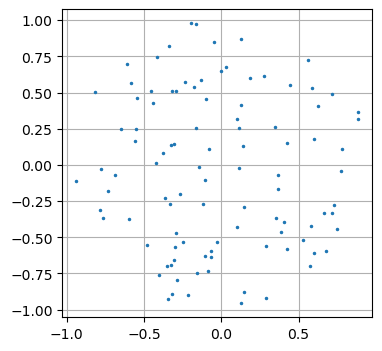

In [2]:
np.random.seed(2023)
x, y = uniform_circle_points(n=100)
plt.figure(figsize=(4,4))
plt.plot(x,y,'.',markersize = 3)
plt.grid()
plt.show()

Expected output of the above block:

<img src="../figures/uniform_circle_points.png">

Then, we feed the coordinates of the points into a `scipy.spatial.ConvexHull` object `CH`.

In [3]:
CH = scipy.spatial.ConvexHull(np.stack((x,y)).T)

From here, we can access the attributes `area` and `volume` to respectively obtain the perimeter and area of the convex hull of the set of points. The naming might seem bizarre, but this is because `ConvexHull` assumes an arbitrary number of dimensions, and the names of the attributes are the n-dimensional analogues of the 2-dimensional quantities.

In [4]:
CH.volume

2.571391005279311

Expected output of the above block:
```
2.571391005279311
```

In [5]:
CH.area

5.834980515381815

Expected output of the above block:
```
5.834980515381815
```

Indeed, if we take a larger sample of points, we get a volume close to $\pi r^2$ and area close to $2\pi r$ (where $r=1$ is the radius of the circle), which corresponds to the well-known formulas for the area and perimeter of a circle.

In [6]:
np.random.seed(2023)
x_large, y_large = uniform_circle_points(n=1000000)
CH_large = scipy.spatial.ConvexHull(np.stack((x_large,y_large)).T)
CH_large.volume

3.1405514469565534

Expected output of the above block:
```
3.1405514469565534
```

In [7]:
CH_large.area

6.282401463068909

Expected output of the above block:
```
6.282401463068909
```

We can also access the indices of the exact points making up the vertices of the convex hull by accessing the `vertices` attribute. As with the documentation of `scipy.spatial.ConvexHull`, the points will be in counter-clockwise order. By doing so, we can draw an outline of the points in the graph.

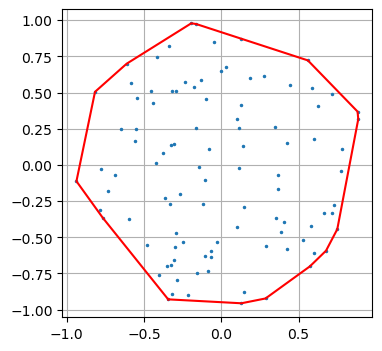

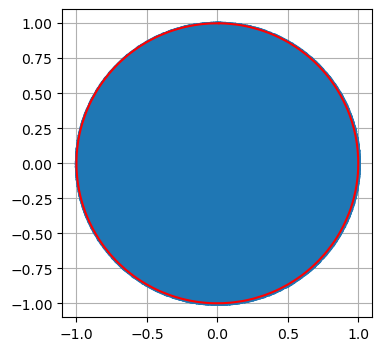

In [8]:
# For the smaller sample
plt.figure(figsize=(4,4))
plt.plot(x,y,'.',markersize = 3)
CH_idxs = np.concatenate((CH.vertices, np.array([CH.vertices[0]])))
plt.plot(x[CH_idxs], y[CH_idxs],'r')
plt.grid()

# For the larger sample
plt.figure(figsize=(4,4))
plt.plot(x_large,y_large,'.',markersize = 3)
plt.plot(x_large[CH_large.vertices], y_large[CH_large.vertices],'r')
plt.grid()

Expected output of the above block:

<img src="../figures/smaller_sample.png">
<img src="../figures/larger_sample.png">

## Second condition: Computing Peacock's test statistic

(This section is more involved)

### Preliminaries

Peacock's test is essentially a 2-dimensional (2D) analogue of the Kolmogorov-Smirnov (KS) test. For the second condition, we want to perform a 1-sample variant of the test against a uniform distribution on a circle with centre $(x_0,y_0)=(0,0)$ in Cartesian coordinates and radius $R=0.5$. Leaving $x_0$, $y_0$, and $R$ arbitrary, the equation of this circle is

$\begin{align}
    (x-x_0)^2 + (y-y_0)^2 &= R^2 & \text{(1)}
\end{align}$

But for convenience, we can shift the entire circle (and all data points) to make it centred about the origin by deducting $(x_0,y_0)$ from their respective coordinates. This makes the equation of the circle more standard as 

$\begin{align}
    x^2 + y^2 &= R^2 & \text{(2)}
\end{align}$

and we can now assume that $(x_0,y_0) = (0,0)$. Rearranging $(2)$ in terms of $x$ and $y$, we get the coordinates of any point on the shifted circle as

$\begin{align*}
    x &= \pm\sqrt{R^2 - y^2} & \text{(3)} \\
    y &= \pm\sqrt{R^2 - x^2} & \text{(4)}
\end{align*}$

Now, to obtain Peacock's test statistic, for any given point $(x_1,y_1)$ on the 2D plane relative to the shifted circle, we need to compute the probabilities that a point could lie more to its top right, top left, bottom left, and bottom right than its current position assuming a uniform distribution on the same circle. There are a number of cases that we need to consider in the computation, and we shall split the cases into the number of quadrants with non-zero probability generated when a vertical and horizontal line is drawn at $(x_1,y_1)$. This number could be 4, 3, 2, or 1, as respectively indicated by the yellow, green, black, and cyan regions below which the `split_quads` function identifies.

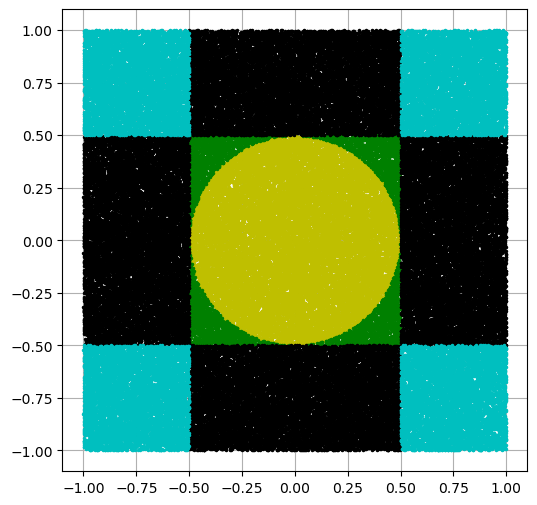

In [9]:
x = np.random.rand(100000)*2 - 1
y = np.random.rand(100000)*2 - 1
x_4quad, y_4quad, x_3quad, y_3quad, x_2quad, y_2quad, x_1quad, y_1quad = split_quads(x, y, R = 0.5)
plt.figure(figsize=(6,6))
plt.plot(x_4quad, y_4quad, 'y.', markersize = 3)
plt.plot(x_3quad, y_3quad, 'g.', markersize = 3)
plt.plot(x_2quad, y_2quad, 'k.', markersize = 3)
plt.plot(x_1quad, y_1quad, 'c.', markersize = 3)
plt.grid()

Expected output of the above block:

<img src="../figures/circle_regions.png">

### Case 1: 4 non-zero quadrants, i.e. $(x_1,y_1)$ lies in circle

In this case, $x_1^2 + y_1^2 < R^2$, and our situation is exemplified by finding the areas of the blue $\left(A^{(\text{TR})}\right)$, grey $\left(A^{(\text{TL})}\right)$, yellow $\left(A^{(\text{BL})}\right)$, and green $\left(A^{(\text{BR})}\right)$ areas in the figure below, divided by a normalising constant $\frac{1}{\pi R^2}$ (i.e., the reciprocal of the area of the circle) to make the probability distribution function (PDF) integrate to 1.

<img width=300 src="../figures/circle01.png">

The areas are relatively easy to find if we split each area $A^{(k)}$ for $k\in\{\text{TR}, \text{TL}, \text{BL}, \text{BR}\}$ into two parts: the area of a segment $A^{(k)}_{\text{s}}$ (lighter-coloured) and the area of a right-angled triangle $A^{(k)}_{\text{t}}$ (darker-coloured). To find the areas of the right-angled triangles, we simply need to find the intersection points between the vertical/horizontal lines with coordinates at $(x_1,y_1)$ and the circle. Let the required $x$-coordinates left and right of $x_1$ be $x_L, x_R$, and the required $y$-coordinates on top of and below $y_1$ be $y_T, y_B$.

<img width=400 src="../figures/circle02.png">

Since the intersection points lie on the circle, we can perform simple substitutions of the known coordinates $(x_1,y_1)$ into $(3)$ and $(4)$ to get

$\begin{align*}
    x_L &= -\sqrt{R^2 - y_1^2} & \text{(5)} \\
    x_R &=  \sqrt{R^2 - y_1^2} & \text{(6)} \\
    y_T &=  \sqrt{R^2 - x_1^2} & \text{(7)} \\
    y_B &= -\sqrt{R^2 - x_1^2} & \text{(8)}
\end{align*}$

We make a sample plot of a circle and the corresponding points of interest as an illustration:

In [10]:
R = 1.5
theta = np.linspace(0,2*np.pi,1000)
x , y  = R*np.cos(theta),                  R*np.sin(theta)
x1, y1 = np.array([0.75]),                 np.array([0.5])
xL, xR = np.array([-np.sqrt(R**2-y1**2)]), np.array([ np.sqrt(R**2-y1**2)])
yU, yD = np.array([ np.sqrt(R**2-x1**2)]), np.array([-np.sqrt(R**2-x1**2)])

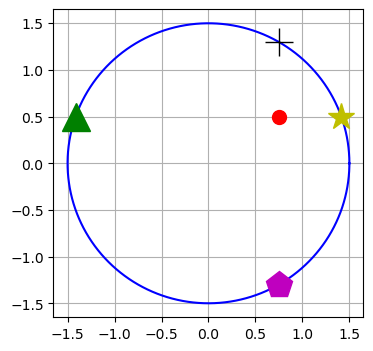

In [11]:
plt.figure(figsize=(4,4))
plt.plot(x,y,'b')
plt.plot(x1,y1,'r.',markersize=20)
plt.plot(xL,y1,'g^',markersize=20)
plt.plot(xR,y1,'y*',markersize=20)
plt.plot(x1,yU,'k+',markersize=20)
plt.plot(x1,yD,'mp',markersize=20)
plt.grid()

Expected output of the above block:

<img src="../figures/case1a.png">

This means that we can use the classic half-base-times-height area formula to obtain

$\begin{align*}
    A^{(\text{TR})}_{\text{t}} &= \frac{1}{2}(x_{\text{R}}-x_1)(y_{\text{T}}-y_1) & \text{(9)} \\
    A^{(\text{TL})}_{\text{t}} &= \frac{1}{2}(x_1-x_{\text{L}})(y_{\text{T}}-y_1) & \text{(10)} \\
    A^{(\text{BL})}_{\text{t}} &= \frac{1}{2}(x_1-x_{\text{L}})(y_1-y_{\text{B}}) & \text{(11)} \\
    A^{(\text{BR})}_{\text{t}} &= \frac{1}{2}(x_{\text{R}}-x_1)(y_1-y_{\text{B}}) & \text{(12)}
\end{align*}$

The area of the segments $A^{(k)}_{\text{s}}$ can be obtained by the standard formula

$\begin{align}
    A^{(k)}_{\text{s}} &= \frac{R^2}{2}\left(\theta^{(k)}-\sin\left(\theta^{(k)}\right)\right) & \text{(13)}
\end{align}$

where $\theta^{(k)}$ is the angle, in radians, subtended the respective arcs.

To find $\theta^{(k)}$, we first need to convert the coordinates of the intersection points from Cartesian to polar form. This can be done by a function `polar` that converts Cartesian $(x,y)$ coordinates into polar $(r, \theta)$ coordinates. Note that `arctan2(y,x)` is a "clever" function that gives the correct angles in radians regardless of input (with $x$ and $y$ inputs reversed), even if $x=0$ (which should return $\operatorname{sgn}(y)\frac{\pi}{2}$). The "correct" angles are defined as positive values in the first and second quadrant, and negative values in the third and fourth quadrant. The values of `arctan2(y,x)` lie in the interval $(-\pi,\pi]$, and `arctan2(0,0)` is defined as 0. Note that `polar` does not reverse the $x$ and $y$ inputs.

In [12]:
polar = lambda x, y: (np.sqrt(x**2+y**2), np.arctan2(y, x))

Some sample inputs:

In [13]:
print(polar(0,0))
print(polar(-1,0), polar(1,0), polar(0,-1), polar(0,1))
print(polar(3,4), polar(-3,4), polar(3,-4), polar(-3,-4))

(0.0, 0.0)
(1.0, 3.141592653589793) (1.0, 0.0) (1.0, -1.5707963267948966) (1.0, 1.5707963267948966)
(5.0, 0.9272952180016122) (5.0, 2.214297435588181) (5.0, -0.9272952180016122) (5.0, -2.214297435588181)


Expected output of the above block:
```
(0.0, 0.0)
(1.0, 3.141592653589793) (1.0, 0.0) (1.0, -1.5707963267948966) (1.0, 1.5707963267948966)
(5.0, 0.9272952180016122) (5.0, 2.214297435588181) (5.0, -0.9272952180016122) (5.0, -2.214297435588181)
```

In other words,

$\begin{align*}
    (x_R,y_1) &:= (r_{R1}, \theta_{R1}) = \left(\sqrt{x_R^2+y_1^2} \ , \ \text{arctan2}\left(y_1,x_R\right)\right)&\text{(14)}\\
    (x_1,y_T) &:= (r_{1T}, \theta_{1T}) = \left(\sqrt{x_1^2+y_T^2} \ , \ \text{arctan2}\left(y_T,x_1\right)\right)&\text{(15)}\\
    (x_L,y_1) &:= (r_{L1}, \theta_{L1}) = \left(\sqrt{x_L^2+y_1^2} \ , \ \text{arctan2}\left(y_1,x_L\right)\right)&\text{(16)}\\
    (x_1,y_B) &:= (r_{1B}, \theta_{1B}) = \left(\sqrt{x_1^2+y_B^2} \ , \ \text{arctan2}\left(y_B,x_1\right)\right)&\text{(17)}
\end{align*}$

but we don't actually need the values $r_{R1}, r_{1T}, r_{L1}, r_{1B}$ here (it's just put here for completeness/reference).

In polar form, finding $\theta^{(k)}$ is easy:

$\begin{align*}
    \theta^{(\text{TR})} &= \min\left(\left|\theta_{R1} - \theta_{1T}\right|, 2\pi-\left|\theta_{R1} - \theta_{1T}\right|\right) & \text{(18)} \\
    \theta^{(\text{TL})} &= \min\left(\left|\theta_{1T} - \theta_{L1}\right|, 2\pi-\left|\theta_{1T} - \theta_{L1}\right|\right) & \text{(19)} \\
    \theta^{(\text{BL})} &= \min\left(\left|\theta_{L1} - \theta_{1B}\right|, 2\pi-\left|\theta_{L1} - \theta_{1B}\right|\right) & \text{(20)} \\
    \theta^{(\text{BR})} &= \min\left(\left|\theta_{1B} - \theta_{R1}\right|, 2\pi-\left|\theta_{1B} - \theta_{R1}\right|\right) & \text{(21)}
\end{align*}$

This is because for any two points $(r_I,\theta_I)$ and $(r_J,\theta_J)$ in polar coordinates, one of the angles between them must be $\left|\theta_I-\theta_J\right|$. This could be the larger one or the smaller one, but in either case, the other angle must be $2\pi-\left|\theta_I-\theta_J\right|$ since their sum must be a full revolution of $2\pi$. When finding the angles of the subtended arcs in this case, it must be the smaller one, so we just take the minimum of the two possibilities.

See https://stackoverflow.com/questions/1878907/how-can-i-find-the-smallest-difference-between-two-angles-around-a-point for more detailed information and discussion.

The full calculation is performed by the `quadrant_probabilities_4` function, with some examples shown below:

[0.0703145  0.18200129 0.24160434 0.50607988]
[0.18200129 0.0703145  0.50607988 0.24160434]
[0.50607988 0.24160434 0.18200129 0.0703145 ]
[0.24160434 0.50607988 0.0703145  0.18200129]
[1. 1. 1. 1.]
[0.         0.04203933]
[ 0.5        -0.00783101]
[0.5        0.57891843]
[ 0.         -0.00783101]
[1.         0.60529574]


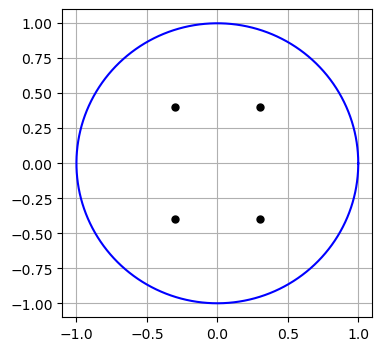

In [14]:
x = np.array([0.3, -0.3,  0.3, -0.3])
y = np.array([0.4,  0.4, -0.4, -0.4])
a, b, c, d = quadrant_probabilities_4(x,y)
print(a)
print(b)
print(c)
print(d)
print(a+b+c+d)

theta = np.linspace(0, 2*np.pi, 1000)
x_circ, y_circ = np.cos(theta), np.sin(theta)
plt.figure(figsize=(4,4))
plt.plot(x_circ, y_circ, 'b')
plt.plot(x,y,'k.',markersize=10)
plt.grid()

x_bad = np.array([1, 0.9])
y_bad = np.array([0, 0.9])
a, b, c, d = quadrant_probabilities_4(x_bad,y_bad)
print(a)
print(b)
print(c)
print(d)
print(a+b+c+d)

Expected output of the above block:
```
[0.0703145  0.18200129 0.24160434 0.50607988]
[0.18200129 0.0703145  0.50607988 0.24160434]
[0.50607988 0.24160434 0.18200129 0.0703145 ]
[0.24160434 0.50607988 0.0703145  0.18200129]
[1. 1. 1. 1.]
Warning: quadrant_probabilities_4 assumes all points lie within the circle but not all of the given points do. Answers may wrongly involve negative numbers or nans.
[0.         0.04203933]
[ 0.5        -0.00783101]
[0.5        0.57891843]
[ 0.         -0.00783101]
[1.         0.60529574]
```
<img src="../figures/case1b.png">

### Case 2: 3 non-zero quadrants, i.e. $(x_1,y_1)$ lies outside circle, but not outside square circumscribing circle

In this case, $x_1^2 + y_1^2 \geq R^2$, but $|x_1| < R$ and $|y_1| < R$. Exactly one of the quadrants must be empty, and our situation can be split into four distinct cases below for each possible quadrant that could be empty:

<img width=300 src="../figures/circle03.png"><img width=300 src="../figures/circle04.png">

<img width=300 src="../figures/circle06.png"><img width=300 src="../figures/circle05.png">

In all cases, the four (now possibly overlapping) intersection points can still be obtained using equations $(5)$, $(6)$, $(7)$, and $(8)$, but there is no need to find the area of any triangle any longer. All areas can be computed using equation $(13)$ (note that for the bigger segment, we have $\theta^{(k)} > \pi$ and this makes the sign flip from minus to plus, effectively turning the subtraction of the isoceles triangle into an addition as desired to compute the bigger segment. Then, as usual, we divide the areas by a normalising constant $\frac{1}{\pi R^2}$ (i.e., the reciprocal of the area of the circle) to make the probability distribution function (PDF) integrate to 1. In code, we identify each of the four cases with boolean statements strung together in a single line and this is performed by `quadrant_probabilities_2`. Some examples are as follows:

[0.         0.04538091 0.15499793 0.79962116]
[0.04538091 0.         0.79962116 0.15499793]
[0.79962116 0.15499793 0.04538091 0.        ]
[0.15499793 0.79962116 0.         0.04538091]
[1. 1. 1. 1.]
However, not all of the given points satisfy this condition. Answers may wrongly involve negative numbers or nans.
[0. 0.]
[0.         0.07475069]
[0.         0.81649543]
[0.         0.10875388]
[0. 1.]


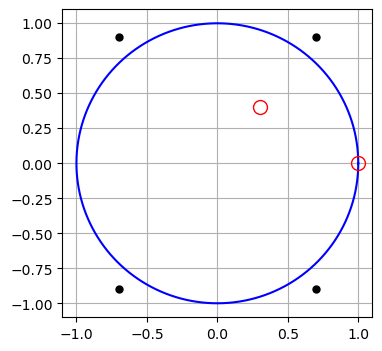

In [15]:
x = np.array([0.7, -0.7,  0.7, -0.7])
y = np.array([0.9,  0.9, -0.9, -0.9])
a, b, c, d = quadrant_probabilities_3(x,y)
print(a)
print(b)
print(c)
print(d)
print(a+b+c+d)

x_bad = np.array([1, 0.3])
y_bad = np.array([0, 0.4])
a, b, c, d = quadrant_probabilities_3(x_bad,y_bad)
print(a)
print(b)
print(c)
print(d)
print(a+b+c+d)

theta = np.linspace(0, 2*np.pi, 1000)
x_circ, y_circ = np.cos(theta), np.sin(theta)
plt.figure(figsize=(4,4))
plt.plot(x_circ, y_circ, 'b')
plt.plot(x,y,'k.',markersize=10)
plt.plot(x_bad,y_bad,'ro',markersize=10,fillstyle='none')
plt.grid()

Expected output of the above block:
```
[0.         0.04538091 0.15499793 0.79962116]
[0.04538091 0.         0.79962116 0.15499793]
[0.79962116 0.15499793 0.04538091 0.        ]
[0.15499793 0.79962116 0.         0.04538091]
[1. 1. 1. 1.]
Warning: quadrant_probabilities_3 assumes all points lie outside the circle but not the square circumscribing the circle.
However, not all of the given points satisfy this condition. Answers may wrongly involve negative numbers or nans.
[0. 0.]
[0.         0.07475069]
[0.         0.81649543]
[0.         0.10875388]
[0. 1.]
```
<img src="../figures/case2.png">

### Case 3: 2 non-zero quadrants, i.e. $(x_1,y_1)$ has exactly one coordinate with magnitude greater than circle radius

In this case, exactly one (and not both) of $|x_1| \geq R$ and $|y_1| \geq R$ is true. Exactly two adjacent quadrants must be empty, and our situation can be split into four distinct cases below for each possible pair of quadrants that could be empty:

<img width=300 src="../figures/circle09.png"><img width=300 src="../figures/circle07.png">

<img width=300 src="../figures/circle08.png"><img width=300 src="../figures/circle10.png">

In all cases, there are now only two (possibly overlapping) intersection points, but they can still be obtained using equations $(5)$, $(6)$, $(7)$, and $(8)$, where the choice of equation must be done carefully to avoid taking the square root of a negative number (i.e., accidentally computing for intersection points when there are none).

The blue and grey areas can be computed using equation $(13)$, and the yellow area can be obtained by deducting the sum of the blue and grey areas from the total area of the circle. Then, as usual, we divide the areas by a normalising constant $\frac{1}{\pi R^2}$ (i.e., the reciprocal of the area of the circle) to make the probability distribution function (PDF) integrate to 1. In code, we identify each of the four cases with boolean statements strung together in a single line and this is performed by `quadrant_probabilities_2`. Some examples are as follows:

[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0.5        0.5        0.68808117 0.68808117 0.25231579 0.25231579]
[0.5        0.5        0.31191883 0.31191883 0.74768421 0.74768421]
[1. 1. 1. 1. 1. 1.]

[0. 0. 0. 0. 0. 0.]
[0.5        0.05204402 0.62646996 0.5        0.05204402 0.62646996]
[0.5        0.94795598 0.37353004 0.5        0.94795598 0.37353004]
[0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1.]

[0.5        0.5        0.37353004 0.37353004 0.85762151 0.85762151]
[0.5        0.5        0.62646996 0.62646996 0.14237849 0.14237849]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1.]

[0.5        0.0940602  0.68808117 0.5        0.0940602  0.68808117]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0.5        0.9059398  0.31191883 0.5        0.9059398  0.31191883]
[1. 1. 1. 1. 1. 1.]

However, not all of the given points satisfy this condition. Answers may wrongly involve negative numbers or nans.
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.

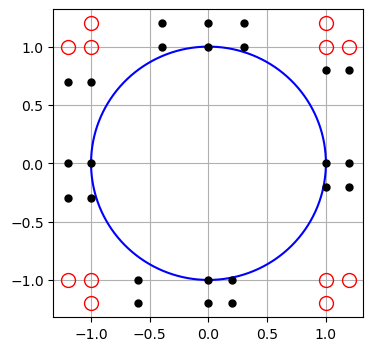

In [16]:
x = np.array([ 0,    0,  0.3,  0.3, -0.4, -0.4, 
               1,    1,    1,  1.2,  1.2,  1.2, 
               0,    0,  0.2,  0.2, -0.6, -0.6,
              -1,   -1,   -1, -1.2, -1.2, -1.2,])
y = np.array([ 1,  1.2,    1,  1.2,    1,  1.2, 
               0,  0.8, -0.2,    0,  0.8, -0.2, 
              -1, -1.2,   -1, -1.2,   -1, -1.2,
               0,  0.7, -0.3,    0,  0.7, -0.3,])
a, b, c, d = quadrant_probabilities_2(x,y)
for start_idx, end_idx in zip(range(0,19,6), range(6,25,6)):
    print(a[start_idx:end_idx])
    print(b[start_idx:end_idx])
    print(c[start_idx:end_idx])
    print(d[start_idx:end_idx])
    print((a+b+c+d)[start_idx:end_idx])
    print()

x_bad = np.array([1,   1, 1.2, -1,  -1, -1.2,  1,    1, 1.2, -1,   -1, -1.2])
y_bad = np.array([1, 1.2,   1,  1, 1.2,    1, -1, -1.2,  -1, -1, -1.2,   -1])
a, b, c, d = quadrant_probabilities_2(x_bad,y_bad)
print(a)
print(b)
print(c)
print(d)
print(a+b+c+d)

theta = np.linspace(0, 2*np.pi, 1000)
x_circ, y_circ = np.cos(theta), np.sin(theta)
plt.figure(figsize=(4,4))
plt.plot(x_circ, y_circ, 'b')
plt.plot(x,y,'k.',markersize=10)
plt.plot(x_bad,y_bad,'ro',markersize=10,fillstyle='none')
plt.grid()

Expected output of the above block:
```
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0.5        0.5        0.68808117 0.68808117 0.25231579 0.25231579]
[0.5        0.5        0.31191883 0.31191883 0.74768421 0.74768421]
[1. 1. 1. 1. 1. 1.]

[0. 0. 0. 0. 0. 0.]
[0.5        0.05204402 0.62646996 0.5        0.05204402 0.62646996]
[0.5        0.94795598 0.37353004 0.5        0.94795598 0.37353004]
[0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1.]

[0.5        0.5        0.37353004 0.37353004 0.85762151 0.85762151]
[0.5        0.5        0.62646996 0.62646996 0.14237849 0.14237849]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1.]

[0.5        0.0940602  0.68808117 0.5        0.0940602  0.68808117]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0.5        0.9059398  0.31191883 0.5        0.9059398  0.31191883]
[1. 1. 1. 1. 1. 1.]

Warning: quadrant_probabilities_2 assumes all points have exactly one (and not both) coordinates with magnitude larger than R = 1.
However, not all of the given points satisfy this condition. Answers may wrongly involve negative numbers or nans.
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
```
<img src="../figures/case3.png">

### Case 4: 1 non-zero quadrant

In this case, both $|x_1| \geq R$ and $|y_1| \geq R$, and the entire area of the circle lies in a single quadrant. This is the easiest case, because we can just assign a value of 1 to the quadrant that the circle lies in, and a value of 0 to all other quadrants. To determine this quadrant, we just check the position of $(x_1,y_1)$ relative to the centre of the circle. In other words (assuming $R > 0$),

$\begin{align*}
    A^{(\text{TR})} &= \begin{cases} 1, & \text{ if } x_1 > x_0 \text{ and } y_1 > y_0 \\ 0, & \text{ otherwise } \end{cases} & \text{(22)} \\
    A^{(\text{TL})} &= \begin{cases} 1, & \text{ if } x_1 < x_0 \text{ and } y_1 > y_0 \\ 0, & \text{ otherwise } \end{cases} & \text{(23)} \\
    A^{(\text{BL})} &= \begin{cases} 1, & \text{ if } x_1 < x_0 \text{ and } y_1 < y_0 \\ 0, & \text{ otherwise } \end{cases} & \text{(24)} \\
    A^{(\text{BR})} &= \begin{cases} 1, & \text{ if } x_1 > x_0 \text{ and } y_1 < y_0 \\ 0, & \text{ otherwise } \end{cases} & \text{(25)}
\end{align*}$

The full calculation is performed by the `quadrant_probabilities_1` function, with some examples shown below:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


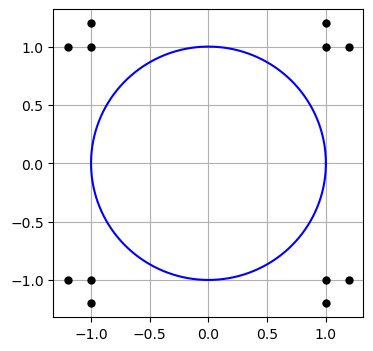

In [17]:
x = np.array([1,   1, 1.2, -1,  -1, -1.2,  1,    1, 1.2, -1,   -1, -1.2])
y = np.array([1, 1.2,   1,  1, 1.2,    1, -1, -1.2,  -1, -1, -1.2,   -1])
a, b, c, d = quadrant_probabilities_1(x,y)
print(a)
print(b)
print(c)
print(d)
print(a+b+c+d)

theta = np.linspace(0, 2*np.pi, 1000)
x_circ, y_circ = np.cos(theta), np.sin(theta)
plt.figure(figsize=(4,4))
plt.plot(x_circ, y_circ, 'b')
plt.plot(x,y,'k.',markersize=10)
plt.grid()

Expected output of the above block:
```
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
```
<img src="../figures/case4.png">

### Subsuming all 4 cases into a single function

Now, we subsume all the 4 cases into a single function `quadrant_probabilities` and explore a few test cases:

In [18]:
x4 = np.array([0.3, -0.3,  0.3, -0.3, 
               0.4,  0.4, -0.4, -0.4, 
               1/np.sqrt(2), -1/np.sqrt(2),  1/np.sqrt(2), -1/np.sqrt(2), 
               0])
y4 = np.array([0.4,  0.4, -0.4, -0.4, 
               0.3, -0.3,  0.3, -0.3, 
               1/np.sqrt(2),  1/np.sqrt(2), -1/np.sqrt(2), -1/np.sqrt(2), 
               0])
x3 = np.array([0.7, -0.7,  0.7, -0.7, 
               0.9,  0.9, -0.9, -0.9])
y3 = np.array([0.9,  0.9, -0.9, -0.9, 
               0.7, -0.7,  0.7, -0.7])
x2 = np.array([ 0,    0,  0.3,  0.3, -0.4, -0.4, 
                1,    1,    1,  1.2,  1.2,  1.2, 
                0,    0,  0.2,  0.2, -0.6, -0.6,
               -1,   -1,   -1, -1.2, -1.2, -1.2,])
y2 = np.array([ 1,  1.2,    1,  1.2,    1,  1.2, 
                0,  0.8, -0.2,    0,  0.8, -0.2, 
               -1, -1.2,   -1, -1.2,   -1, -1.2,
                0,  0.7, -0.3,    0,  0.7, -0.3,])
x1 = np.array([1,   1, 1.2, -1,  -1, -1.2,  1,    1, 1.2, -1,   -1, -1.2])
y1 = np.array([1, 1.2,   1,  1, 1.2,    1, -1, -1.2,  -1, -1, -1.2,   -1])

x = np.concatenate((x4, x3, x2, x1))
y = np.concatenate((y4, y3, y2, y1))

a,b,c,d = quadrant_probabilities(x, y)

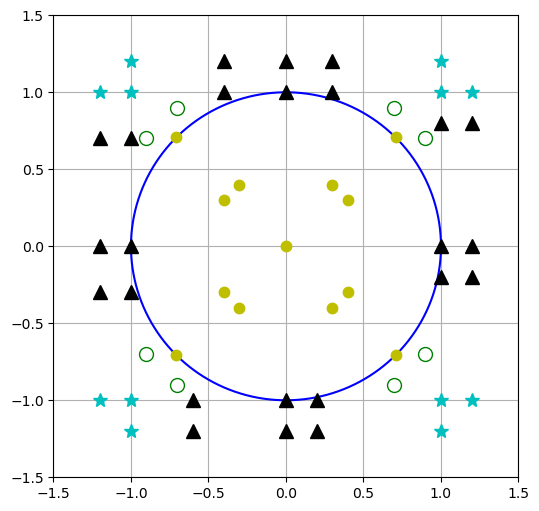

In [19]:
theta = np.linspace(0,2*np.pi,1000)
x_circ, y_circ = np.cos(theta), np.sin(theta)
plt.figure(figsize=(6,6))
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.plot(x_circ, y_circ, 'b')
plt.plot(x4, y4, 'y.', markersize = 15)
plt.plot(x3, y3, 'go', markersize = 10, fillstyle='none')
plt.plot(x2, y2, 'k^', markersize = 10)
plt.plot(x1, y1, 'c*', markersize = 10)
plt.grid()

Expected output of the above block:

<img src="../figures/caseall.png">

In [20]:
for i in [a,b,c,d]:
    print(i)
print(a+b+c+d)

[7.03144964e-02 1.82001291e-01 2.41604336e-01 5.06079876e-01
 7.03144964e-02 1.82001291e-01 2.41604336e-01 5.06079876e-01
 1.96173613e-33 9.08450569e-02 9.08450569e-02 8.18309886e-01
 2.50000000e-01 0.00000000e+00 4.53809089e-02 1.54997927e-01
 7.99621164e-01 0.00000000e+00 4.53809089e-02 1.54997927e-01
 7.99621164e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.00000000e-01 5.00000000e-01 3.73530039e-01
 3.73530039e-01 8.57621510e-01 8.57621510e-01 5.00000000e-01
 9.40602022e-02 6.88081168e-01 5.00000000e-01 9.40602022e-02
 6.88081168e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00]
[1.82001291e-01 7.03144964e-02 5.06079876e-01 2.41604336e-01
 2.41604336e-01 5.06079876e-01 7.03144964e-02 1.82001291e-01
 9.0845

Expected output of the print statements:
```
[7.03144964e-02 1.82001291e-01 2.41604336e-01 5.06079876e-01
 7.03144964e-02 1.82001291e-01 2.41604336e-01 5.06079876e-01
 1.96173613e-33 9.08450569e-02 9.08450569e-02 8.18309886e-01
 2.50000000e-01 0.00000000e+00 4.53809089e-02 1.54997927e-01
 7.99621164e-01 0.00000000e+00 4.53809089e-02 1.54997927e-01
 7.99621164e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.00000000e-01 5.00000000e-01 3.73530039e-01
 3.73530039e-01 8.57621510e-01 8.57621510e-01 5.00000000e-01
 9.40602022e-02 6.88081168e-01 5.00000000e-01 9.40602022e-02
 6.88081168e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00]
[1.82001291e-01 7.03144964e-02 5.06079876e-01 2.41604336e-01
 2.41604336e-01 5.06079876e-01 7.03144964e-02 1.82001291e-01
 9.08450569e-02 1.96173613e-33 8.18309886e-01 9.08450569e-02
 2.50000000e-01 4.53809089e-02 0.00000000e+00 7.99621164e-01
 1.54997927e-01 1.54997927e-01 7.99621164e-01 0.00000000e+00
 4.53809089e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000000e-01
 5.20440193e-02 6.26469961e-01 5.00000000e-01 5.20440193e-02
 6.26469961e-01 5.00000000e-01 5.00000000e-01 6.26469961e-01
 6.26469961e-01 1.42378490e-01 1.42378490e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[5.06079876e-01 2.41604336e-01 1.82001291e-01 7.03144964e-02
 5.06079876e-01 2.41604336e-01 1.82001291e-01 7.03144964e-02
 8.18309886e-01 9.08450569e-02 9.08450569e-02 1.96173613e-33
 2.50000000e-01 7.99621164e-01 1.54997927e-01 4.53809089e-02
 0.00000000e+00 7.99621164e-01 1.54997927e-01 4.53809089e-02
 0.00000000e+00 5.00000000e-01 5.00000000e-01 6.88081168e-01
 6.88081168e-01 2.52315788e-01 2.52315788e-01 5.00000000e-01
 9.47955981e-01 3.73530039e-01 5.00000000e-01 9.47955981e-01
 3.73530039e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[2.41604336e-01 5.06079876e-01 7.03144964e-02 1.82001291e-01
 1.82001291e-01 7.03144964e-02 5.06079876e-01 2.41604336e-01
 9.08450569e-02 8.18309886e-01 1.96173613e-33 9.08450569e-02
 2.50000000e-01 1.54997927e-01 7.99621164e-01 0.00000000e+00
 4.53809089e-02 4.53809089e-02 0.00000000e+00 7.99621164e-01
 1.54997927e-01 5.00000000e-01 5.00000000e-01 3.11918832e-01
 3.11918832e-01 7.47684212e-01 7.47684212e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000000e-01
 9.05939798e-01 3.11918832e-01 5.00000000e-01 9.05939798e-01
 3.11918832e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
```

### Final computation

Now, the test statistic is the maximum difference $D$ between theoretical probabilities and observed fractions of points lying in each quadrant across all data points, multiplied by a normalising constant dependent on the number of samples $N$ and correlation coefficient $r$ of the two dimensions of the samples. The normalising constant is 

$\begin{align*}
    \alpha &= \frac{\sqrt{N}}{1+\sqrt{1-r^2}\left(0.25-\frac{0.75}{\sqrt{N}}\right)} & \text{(26)}
\end{align*}$

so comparing the values of $\alpha D$ between samples can give us a good idea of which sample is more "uniform" than the other by comparing the samples against a theoretical uniform distribution. See "Kolmogorov-Smirnov Test for Two-Dimensional Data" (Press, Teukolsky, 1988) for more information.

Firstly, to compute $D$, we need to compute the observed fractions of points in each quadrant. We use the function `quadrant_fractions` and show a few test cases as follows:

[0.4        0.25       0.08333333 0.08333333 0.         0.27272727
 0.16666667 0.66666667 0.5        0.45454545 0.        ]
[0.2        0.25       0.41666667 0.         0.08333333 0.
 0.08333333 0.16666667 0.2        0.36363636 1.        ]
[0.3        0.33333333 0.41666667 0.58333333 0.75       0.
 0.16666667 0.         0.1        0.09090909 0.        ]
[0.1        0.16666667 0.08333333 0.33333333 0.16666667 0.72727273
 0.58333333 0.16666667 0.2        0.09090909 0.        ]


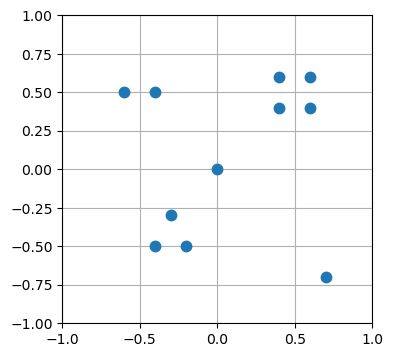

In [21]:
x = np.array([0, 0.4,0.6,0.4,0.6, -0.6,-0.4, -0.4,-0.3,-0.2,  0.7])
y = np.array([0, 0.4,0.4,0.6,0.6,  0.5, 0.5, -0.5,-0.3,-0.5, -0.7])
plt.figure(figsize=(4,4))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(x,y,'.',markersize=15)
plt.grid()

top_right_observed, top_left_observed, bottom_left_observed, bottom_right_observed = quadrant_fractions(x,y)

print(top_right_observed)
print(top_left_observed)
print(bottom_left_observed)
print(bottom_right_observed)

Expected output of the above block:
```
[0.4        0.25       0.08333333 0.08333333 0.         0.27272727
 0.16666667 0.66666667 0.5        0.45454545 0.        ]
[0.2        0.25       0.41666667 0.         0.08333333 0.
 0.08333333 0.16666667 0.2        0.36363636 1.        ]
[0.3        0.33333333 0.41666667 0.58333333 0.75       0.
 0.16666667 0.         0.1        0.09090909 0.        ]
[0.1        0.16666667 0.08333333 0.33333333 0.16666667 0.72727273
 0.58333333 0.16666667 0.2        0.09090909 0.        ]
```
<img src="../figures/casefinal.png">

We compute the differences in theoretical and observed fractions of points lying in each quadrant for each of the above set of points acting as test cases by comparing the outputs of `quadrant_probabilities` against the outputs of `quadrant_fractions`:

In [22]:
top_right_theoretical, top_left_theoretical, bottom_left_theoretical, bottom_right_theoretical = quadrant_probabilities(x,y)

print(top_right_theoretical)
print(top_left_theoretical)
print(bottom_left_theoretical)
print(bottom_right_theoretical)

[0.25       0.05324537 0.02374151 0.02374151 0.00697005 0.18106834
 0.15793068 0.58975353 0.46672906 0.49731541 0.09402816]
[0.25       0.19907042 0.22857428 0.11863698 0.13540844 0.01443277
 0.03757043 0.21474536 0.22135211 0.30718348 0.81191164]
[0.25       0.54861379 0.62904723 0.62904723 0.72221307 0.12794572
 0.21474536 0.03757043 0.09056672 0.06634656 0.09402816]
[2.50000000e-01 1.99070418e-01 1.18636978e-01 2.28574276e-01
 1.35408441e-01 6.76553166e-01 5.89753529e-01 1.57930684e-01
 2.21352110e-01 1.29154547e-01 3.20464172e-05]


Expected output of the above block:
```
[0.25       0.05324537 0.02374151 0.02374151 0.00697005 0.18106834
 0.15793068 0.58975353 0.46672906 0.49731541 0.09402816]
[0.25       0.19907042 0.22857428 0.11863698 0.13540844 0.01443277
 0.03757043 0.21474536 0.22135211 0.30718348 0.81191164]
[0.25       0.54861379 0.62904723 0.62904723 0.72221307 0.12794572
 0.21474536 0.03757043 0.09056672 0.06634656 0.09402816]
[2.50000000e-01 1.99070418e-01 1.18636978e-01 2.28574276e-01
 1.35408441e-01 6.76553166e-01 5.89753529e-01 1.57930684e-01
 2.21352110e-01 1.29154547e-01 3.20464172e-05]
```

In [23]:
top_right_diff    = np.abs(top_right_theoretical-top_right_observed)
top_left_diff     = np.abs(top_left_theoretical-top_left_observed)
bottom_left_diff  = np.abs(bottom_left_theoretical-bottom_left_observed)
bottom_right_diff = np.abs(bottom_right_theoretical-bottom_right_observed)

print(top_right_diff)
print(top_left_diff)
print(bottom_left_diff)
print(bottom_right_diff)

[0.15       0.19675463 0.05959182 0.05959182 0.00697005 0.09165893
 0.00873598 0.07691314 0.03327094 0.04276996 0.09402816]
[0.05       0.05092958 0.18809239 0.11863698 0.05207511 0.01443277
 0.04576291 0.0480787  0.02135211 0.05645289 0.18808836]
[0.05       0.21528046 0.21238057 0.0457139  0.02778693 0.12794572
 0.0480787  0.03757043 0.00943328 0.02456253 0.09402816]
[1.50000000e-01 3.24037515e-02 3.53036451e-02 1.04759057e-01
 3.12582257e-02 5.07195611e-02 6.42019530e-03 8.73598303e-03
 2.13521102e-02 3.82454557e-02 3.20464172e-05]


Expected output of the above block:
```
[0.15       0.19675463 0.05959182 0.05959182 0.00697005 0.09165893
 0.00873598 0.07691314 0.03327094 0.04276996 0.09402816]
[0.05       0.05092958 0.18809239 0.11863698 0.05207511 0.01443277
 0.04576291 0.0480787  0.02135211 0.05645289 0.18808836]
[0.05       0.21528046 0.21238057 0.0457139  0.02778693 0.12794572
 0.0480787  0.03757043 0.00943328 0.02456253 0.09402816]
[1.50000000e-01 3.24037515e-02 3.53036451e-02 1.04759057e-01
 3.12582257e-02 5.07195611e-02 6.42019530e-03 8.73598303e-03
 2.13521102e-02 3.82454557e-02 3.20464172e-05]
```

The test statistic $D$ is just the maximum value across all quadrants and all samples.

In [24]:
D = max(np.max(top_right_diff), np.max(top_left_diff), np.max(bottom_left_diff), np.max(bottom_right_diff))
D

0.21528046072172763

Expected output of the above block:
```
0.21528046072172763
```

We then compute the normalisation coefficient $\alpha$ according to Equation (26):

In [25]:
r = np.corrcoef(x,y)[0,1]
N = len(x)
assert N == len(y)
alpha = np.sqrt(N)/(1+np.sqrt(1-r**2)*(0.25-0.75/np.sqrt(N)))
alpha

3.240017887866992

Expected output of the above block:
```
3.240017887866992
```

The normalised test statistic is thus $\alpha D$:

In [26]:
TDKS_statistic = alpha*D
TDKS_statistic 

0.6975125436466448

Expected output of the above block:
```
0.6975125436466448
```

We can use the function `TDKS_uniform_circle` to get the same values:

In [27]:
TDKS_uniform_circle(x, y, normalise = True)

0.6975125436466448

Expected output of the above block:
```
0.6975125436466448
```

In [28]:
TDKS_uniform_circle(x, y, normalise = False)

0.21528046072172763

Expected output of the above block:
```
0.21528046072172763
```

As a rough confirmation, we randomly generate a set of points from the exact same distribution that the statistical test is to be carried on (uniform distribution over a circle centred on the origin with radius 1): <a name="uniform_circle_n100_s2023">

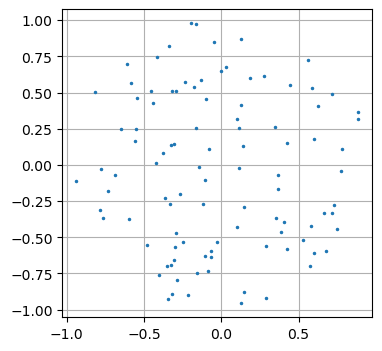

In [29]:
np.random.seed(2023)
x, y = uniform_circle_points(n=100)
plt.figure(figsize=(4,4))
plt.plot(x,y,'.',markersize = 3)
plt.grid()
plt.show()

Expected output of the above block:

<img width=275 src="../figures/uniform_circle_points.png">

In [30]:
TDKS_uniform_circle(x,y)

0.9380662357023231

Expected output of the above block:
```
0.9380662357023231
```

## Combining the two conditions into a single loss

Now, we can combine the convex hull area and Peacock's test statistic into a single loss function by adding a weighted sum of the two values (with non-negative weights). This is done by the `representative_loss` function and we run it on the same test case as the <a href="#uniform_circle_n100_s2023"> previous sub-section </a>.

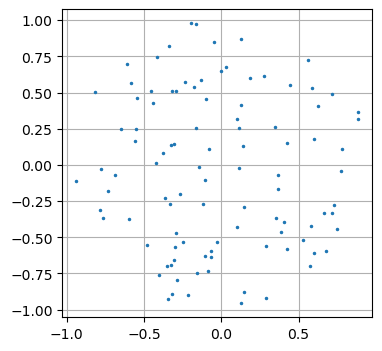

In [31]:
np.random.seed(2023)
x, y = uniform_circle_points(n=100)
plt.figure(figsize=(4,4))
plt.plot(x,y,'.',markersize = 3)
plt.grid()
plt.show()

Expected output of the above block:

<img width=275 src="../figures/uniform_circle_points.png">

If zero weight is given to Peacock's test statistic (`TDKS_uniform_circle_weight`) then just the negative volume of the convex hull is returned.

In [32]:
CH = scipy.spatial.ConvexHull(np.stack((x,y)).T)
-CH.volume

-2.571391005279311

Expected output of the above block:
```
-2.571391005279311
```

In [33]:
assert -CH.volume == representative_loss(x,y, ConvexHull_weight = 1, TDKS_uniform_circle_weight = 0, TDKS_uniform_circle_kwargs = {'R': 1})

If zero weight is given to the convex hull area (`ConvexHull_weight`) then just Peacock's test statistic is returned.

In [34]:
TDKS_uniform_circle(x,y)

0.9380662357023231

Expected output of the above block:
```
0.9380662357023231
```

In [35]:
assert TDKS_uniform_circle(x,y) == representative_loss(x,y, ConvexHull_weight = 0, TDKS_uniform_circle_weight = 1, TDKS_uniform_circle_kwargs = {'R': 1})

The default values of the individual weights in `representative_loss` are of course 1 for both terms:

In [36]:
-CH.volume + TDKS_uniform_circle(x,y)

-1.633324769576988

Expected output of the above block:
```
-1.633324769576988
```

In [37]:
assert representative_loss(x,y) == -CH.volume + TDKS_uniform_circle(x,y)

### Figure 3

The next blocks generate all sub-figures in Figure 3 of our publication:

Representative loss = -0.53; Convex hull area = 0.64; Peacock's test statistic = 0.11


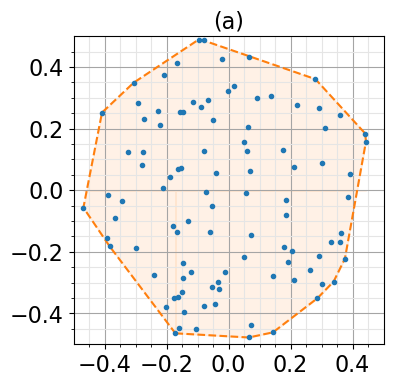

In [38]:
ConvexHull_weight, TDKS_uniform_circle_weight = 1,1
R = 0.5
x0 = 0
y0 = 0
normalise = False

np.random.seed(2023)
x,y = uniform_circle_points(R=0.5)

L = representative_loss(
    x,y,
    ConvexHull_weight = ConvexHull_weight,
    TDKS_uniform_circle_weight = TDKS_uniform_circle_weight,
    TDKS_uniform_circle_kwargs = {
        'R': R,
        'x0': x0,
        'y0': y0,
        'normalise': normalise,
    }
)
A = representative_loss(
    x,y,
    ConvexHull_weight = 1,
    TDKS_uniform_circle_weight = 0,
    TDKS_uniform_circle_kwargs = {
        'R': R,
        'x0': x0,
        'y0': y0,
        'normalise': normalise,
    }
)
D = representative_loss(
    x,y,
    ConvexHull_weight = 0,
    TDKS_uniform_circle_weight = 1,
    TDKS_uniform_circle_kwargs = {
        'R': R,
        'x0': x0,
        'y0': y0,
        'normalise': normalise,
    }
)
print(f"Representative loss = {L:.2f}; Convex hull area = {-A:.2f}; Peacock's test statistic = {D:.2f}")

CH = scipy.spatial.ConvexHull(np.stack((x,y)).T)
CH_idxs = np.concatenate((CH.vertices, np.array([CH.vertices[0]])))
# Note: matplotlib default colour order = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']

plt.figure(figsize=(4,4))
plt.title('(a)',fontsize=16)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.plot(x[CH_idxs], y[CH_idxs], '--', color = '#ff7f0e')
plt.fill_between(x[CH_idxs], y[CH_idxs], alpha=0.1, color='#ff7f0e')
plt.plot(x,y,'.')
plt.xticks(ticks=[-0.4,-0.2,0.0,0.2,0.4],fontsize=16)
plt.yticks(ticks=[-0.4,-0.2,0.0,0.2,0.4],fontsize=16)
plt.grid(which='major', color = '#A5A5A5')
plt.grid(which='minor', color = '#E5E5E5')
plt.minorticks_on()
plt.show()

Expected output of the above block:
```
Representative loss = -0.53; Convex hull area = 0.64; Peacock's test statistic = 0.11
```
<img src="../figures/distribution_ideal.png">

Representative loss = -0.04; Convex hull area = 0.24; Peacock's test statistic = 0.20


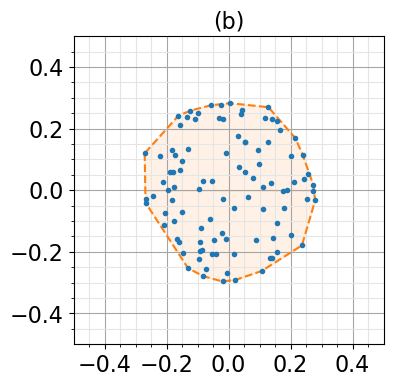

In [39]:
ConvexHull_weight, TDKS_uniform_circle_weight = 1,1
R = 0.5
x0 = 0
y0 = 0
normalise = False

np.random.seed(901)
x,y = uniform_circle_points(R=0.3)

L = representative_loss(
    x,y,
    ConvexHull_weight = ConvexHull_weight,
    TDKS_uniform_circle_weight = TDKS_uniform_circle_weight,
    TDKS_uniform_circle_kwargs = {
        'R': R,
        'x0': x0,
        'y0': y0,
        'normalise': normalise,
    }
)
A = representative_loss(
    x,y,
    ConvexHull_weight = 1,
    TDKS_uniform_circle_weight = 0,
    TDKS_uniform_circle_kwargs = {
        'R': R,
        'x0': x0,
        'y0': y0,
        'normalise': normalise,
    }
)
D = representative_loss(
    x,y,
    ConvexHull_weight = 0,
    TDKS_uniform_circle_weight = 1,
    TDKS_uniform_circle_kwargs = {
        'R': R,
        'x0': x0,
        'y0': y0,
        'normalise': normalise,
    }
)
print(f"Representative loss = {L:.2f}; Convex hull area = {-A:.2f}; Peacock's test statistic = {D:.2f}")

CH = scipy.spatial.ConvexHull(np.stack((x,y)).T)
CH_idxs = np.concatenate((CH.vertices, np.array([CH.vertices[0]])))
# Note: matplotlib default colour order = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']

plt.figure(figsize=(4,4))
plt.title('(b)',fontsize=16)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.plot(x[CH_idxs], y[CH_idxs], '--', color = '#ff7f0e')
plt.fill_between(x[CH_idxs], y[CH_idxs], alpha=0.1, color='#ff7f0e')
plt.plot(x,y,'.')
plt.xticks(ticks=[-0.4,-0.2,0.0,0.2,0.4],fontsize=16)
plt.yticks(ticks=[-0.4,-0.2,0.0,0.2,0.4],fontsize=16)
plt.grid(which='major', color = '#A5A5A5')
plt.grid(which='minor', color = '#E5E5E5')
plt.minorticks_on()
plt.show()

Expected output of the above block:
```
Representative loss = -0.04; Convex hull area = 0.24; Peacock's test statistic = 0.20
```
<img src="../figures/distribution_small.png">

Representative loss = -0.29; Convex hull area = 0.63; Peacock's test statistic = 0.34


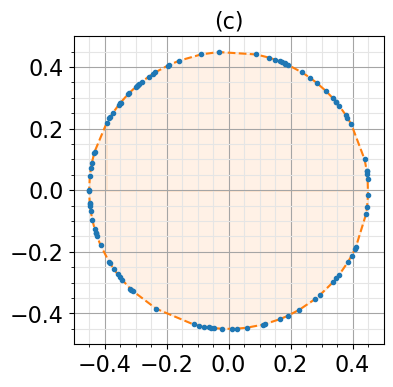

In [40]:
ConvexHull_weight, TDKS_uniform_circle_weight = 1,1
R = 0.5
x0 = 0
y0 = 0
normalise = False

np.random.seed(2023)
theta = np.random.rand(100)*2*np.pi
x,y = 0.45*np.cos(theta), 0.45*np.sin(theta)

L = representative_loss(
    x,y,
    ConvexHull_weight = ConvexHull_weight,
    TDKS_uniform_circle_weight = TDKS_uniform_circle_weight,
    TDKS_uniform_circle_kwargs = {
        'R': R,
        'x0': x0,
        'y0': y0,
        'normalise': normalise,
    }
)
A = representative_loss(
    x,y,
    ConvexHull_weight = 1,
    TDKS_uniform_circle_weight = 0,
    TDKS_uniform_circle_kwargs = {
        'R': R,
        'x0': x0,
        'y0': y0,
        'normalise': normalise,
    }
)
D = representative_loss(
    x,y,
    ConvexHull_weight = 0,
    TDKS_uniform_circle_weight = 1,
    TDKS_uniform_circle_kwargs = {
        'R': R,
        'x0': x0,
        'y0': y0,
        'normalise': normalise,
    }
)
print(f"Representative loss = {L:.2f}; Convex hull area = {-A:.2f}; Peacock's test statistic = {D:.2f}")

CH = scipy.spatial.ConvexHull(np.stack((x,y)).T)
CH_idxs = np.concatenate((CH.vertices, np.array([CH.vertices[0]])))
# Note: matplotlib default colour order = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']

plt.figure(figsize=(4,4))
plt.title('(c)',fontsize=16)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.plot(x[CH_idxs], y[CH_idxs], '--', color = '#ff7f0e')
plt.fill_between(x[CH_idxs], y[CH_idxs], alpha=0.1, color='#ff7f0e')
plt.plot(x,y,'.')
plt.xticks(ticks=[-0.4,-0.2,0.0,0.2,0.4],fontsize=16)
plt.yticks(ticks=[-0.4,-0.2,0.0,0.2,0.4],fontsize=16)
plt.grid(which='major', color = '#A5A5A5')
plt.grid(which='minor', color = '#E5E5E5')
plt.minorticks_on()
plt.show()

Expected output of the above block:
```
Representative loss = -0.29; Convex hull area = 0.63; Peacock's test statistic = 0.34
```
<img src="../figures/distribution_uneven.png">

# Exploration of predictions

We first load the `predictions.csv` file containing the predicted ISO Pleasantness and ISO Eventfulness values for each 30-second window of the full-length recordings in the LCS dataset. The predictions were made with an ensemble of five prediction models pre-trained on the ARAUS data (each one having one fold of the cross-validation set excluded from training), using the method described by Watcharasupat et al. (K. N. Watcharasupat, et al., "Autonomous In-Situ Soundscape Augmentation via Joint Selection of
Masker and Gain," IEEE Signal Processing Letters, pp. 1–5, 2022.).

## Figure 4(a)
Across the entire LCS dataset, we can get the mean and median of predictions as follows:

In [41]:
df_predictions = pd.read_csv('..\\predictions.csv')
df_predictions.describe().loc[['mean','50%'],['isopl_mean','isoev_mean']]

,isopl_mean,isoev_mean
mean,0.109261,-0.118100
50%,0.135899,-0.134308


Expected output of the above block:
```
     | isopl_mean | isoev_mean
-----+------------+------------
mean |  0.109261  |  -0.118100
50%  |  0.135899  |  -0.134308
```

We can also make a KDE plot of the points to have a visual idea of their distributions (may take about 2 minutes to run):

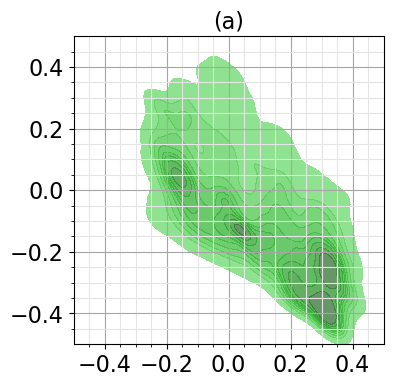

In [42]:
fill = True
alpha = 0.75
thresh = 0.02

plt.figure(figsize=(4,4))
plt.title('(a)',fontsize=16)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
sns.kdeplot(df_predictions,
            x = 'isopl_mean',
            y = 'isoev_mean',
            color = '#2ca02c',
            fill = fill,
            alpha = alpha,
            thresh = thresh)
plt.xticks(ticks=[-0.4,-0.2,0.0,0.2,0.4],fontsize=16)
plt.yticks(ticks=[-0.4,-0.2,0.0,0.2,0.4],fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.grid(which='major', color = '#A5A5A5')
plt.grid(which='minor', color = '#E5E5E5')
plt.minorticks_on()
plt.show()

Expected output of the above block:
    
<img src="../figures/distribution_observed.png">

## `lcs_points`

The `lcs_points` class can help us to organise the predictions and plots as well.

In [43]:
LCS_points = lcs_points()

For instance, we can plot all the points as different colours for each recording location:

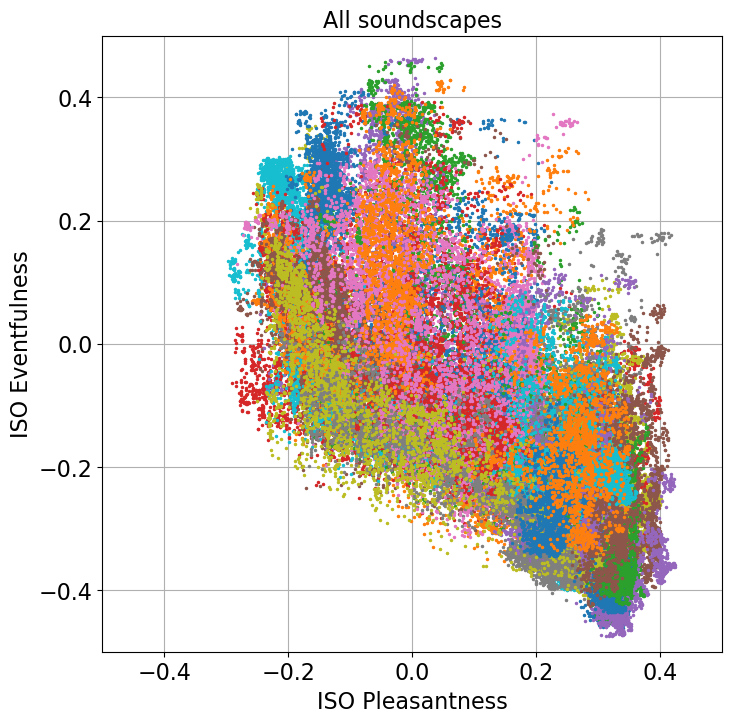

In [44]:
LCS_points.plot_points()

Expected output of the above block:

<img src="../figures/all_soundscapes.png">

We can see the time series of predictions for ISO Pleasantness and ISO Eventfulness by the individual recording location, and plot the points by recording locations as well. For example, we can do it for S0004 (Tampines Central 7) as follows:

In [45]:
LCS_points.predictions['S0004']

,lcs_id,start_idxs,isopl_mean,isoev_mean
0,S0004,0,-0.000158,-0.188922
1,S0004,1,-0.090243,-0.178251
2,S0004,2,-0.180442,-0.145724
3,S0004,3,-0.175092,-0.142261
4,S0004,4,-0.189925,-0.140036
...,...,...,...,...
2289,S0004,2289,0.053629,0.009039
2290,S0004,2290,0.078795,-0.004272
2291,S0004,2291,0.066841,-0.013399
2292,S0004,2292,0.051329,-0.002650


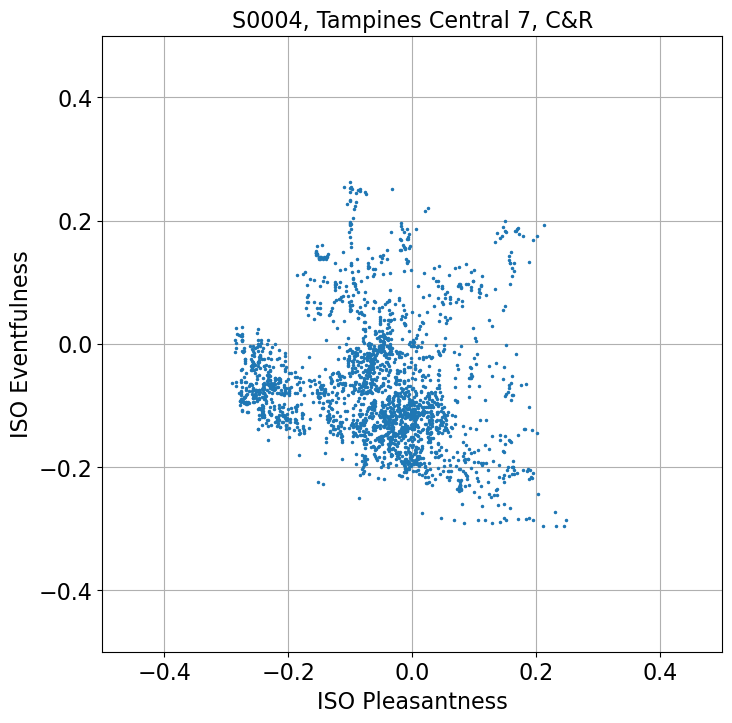

In [46]:
LCS_points.plot_points(plot_type='S0004')

Expected output of the above block:

<img src="../figures/S0004.png">

# Selection algorithm

To finally choose the "representative" set of 1-minute excerpts, we consider each excerpt as a pair of points in the ISO Pleasantness/Eventfulness space obtained from the pre-trained prediction model on the ARAUS dataset. We then choose the excerpts by selecting 62 pairs of points in the space (each associated with consecutive 30-second windows from the prediction model), and extracting the 1-minute excerpts from their associated timestamps `start_idxs` (in seconds).

The selection algorithm is a modified k-medoids algorithm, where we consider the set of points for each soundscape to belong in the same fixed cluster, and we want to pick 62 cluster centres (variable over the evolution of the algorithm) to each represent their own cluster. Starting from an initial random selection of points, we do the following:
1. Consider all possible swaps from the current selection to the database of all points
2. Swap only the single point causing the greatest decrease in loss function value
3. Repeat until there is no more reduction in loss function value

Alternatively, we could have tried out a more "greedy" idea (this is done by setting the `permute` parameter to True in `swap_points`), but we do not do that here:
1. Randomly choose a set of points (corresponding to a single soundscape) for which a swap with the database is to be made
2. Swap the point in that set causing the greatest decrease in loss function value
3. Repeat (without replacement) across all sets of points in the database (corresponding to all soundscapes)
4. Repeat until there is no more reduction in loss function value

## Single seed (seed 12)

As an example, we run the selection algorithm with an initial choice of random points dictated by a seed value of 12. This is the seed value returning the lowest loss function value upon termination of the algorithm among all initial choices dictated by seed values of 1 to 20 (inclusive). To run all 20 seeds, please go to <a href="#twenty_seeds">this section</a>.

Firstly, we have a look at the initial choice of points:

In [3]:
seed_val = 12
LCS_points = lcs_points()
df = LCS_points.random_choice(seed_val = seed_val,restrict=True)
df

,start_idxs,isopl_1st_half,isoev_1st_half,isopl_2nd_half,isoev_2nd_half,prediction_fpath
541,541,0.329222,-0.428398,0.346702,-0.393395,S0001
670,670,-0.110196,0.022129,-0.165886,0.112232,S0002
188,188,0.173938,-0.216595,0.185035,-0.228310,S0003
409,409,-0.021457,0.070234,-0.278593,0.013509,S0004
96,96,0.085825,-0.123188,0.277881,-0.385970,S0005
...,...,...,...,...,...,...
810,810,-0.168610,-0.037293,-0.088134,-0.100451,S0058
951,951,-0.213458,0.126237,-0.139668,0.068301,S0059
1184,1184,0.333331,-0.197281,0.334346,-0.230402,S0060
1373,1373,0.223929,-0.309260,0.240541,-0.224367,S0061


### Figure 4(b)

We can plot the initial choice of points superimposed on the KDE plot of the points for all soundscapes as follows:

Representative loss = 0.06; Convex hull area = 0.29; Peacock's test statistic = 0.35


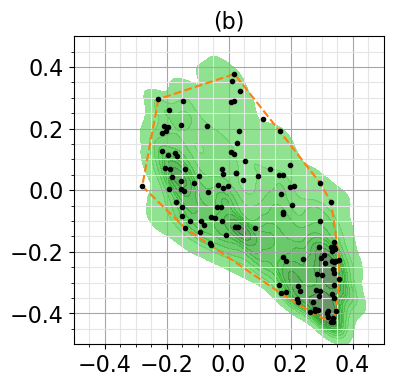

In [5]:
ConvexHull_weight, TDKS_uniform_circle_weight = 1,1
R = 0.5
x0 = 0
y0 = 0
normalise = False
fill = True
alpha = 0.75
thresh = 0.02

x = pd.concat((df['isopl_1st_half'],df['isopl_2nd_half'])).to_numpy().squeeze()
y = pd.concat((df['isoev_1st_half'],df['isoev_2nd_half'])).to_numpy().squeeze()

L = representative_loss(
    x,y,
    ConvexHull_weight = ConvexHull_weight,
    TDKS_uniform_circle_weight = TDKS_uniform_circle_weight,
    TDKS_uniform_circle_kwargs = {
        'R': R,
        'x0': x0,
        'y0': y0,
        'normalise': normalise,
    }
)
A = representative_loss(
    x,y,
    ConvexHull_weight = 1,
    TDKS_uniform_circle_weight = 0,
    TDKS_uniform_circle_kwargs = {
        'R': R,
        'x0': x0,
        'y0': y0,
        'normalise': normalise,
    }
)
D = representative_loss(
    x,y,
    ConvexHull_weight = 0,
    TDKS_uniform_circle_weight = 1,
    TDKS_uniform_circle_kwargs = {
        'R': R,
        'x0': x0,
        'y0': y0,
        'normalise': normalise,
    }
)
print(f"Representative loss = {L:.2f}; Convex hull area = {-A:.2f}; Peacock's test statistic = {D:.2f}")

CH = scipy.spatial.ConvexHull(np.stack((x,y)).T)
CH_idxs = np.concatenate((CH.vertices, np.array([CH.vertices[0]])))
# Note: matplotlib default colour order = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']

plt.figure(figsize=(4,4))
plt.title('(b)',fontsize=16)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
sns.kdeplot(pd.read_csv(os.path.join('..','predictions.csv')),
            x = 'isopl_mean',
            y = 'isoev_mean',
            color = '#2ca02c',
            fill = fill,
            alpha = alpha,
            thresh = thresh)
plt.plot(x[CH_idxs], y[CH_idxs], '--', color = '#ff7f0e')
plt.plot(x,y,'k.')
plt.xticks(ticks=[-0.4,-0.2,0.0,0.2,0.4],fontsize=16)
plt.yticks(ticks=[-0.4,-0.2,0.0,0.2,0.4],fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.grid(which='major', color = '#A5A5A5')
plt.grid(which='minor', color = '#E5E5E5')
plt.minorticks_on()

df.to_csv(os.path.join('..','results',f"Seed_{seed_val:02d}_Epoch_000_Loss_{L:.6f}.csv"),index=False)

Expected output of the above block:

<img src="../figures/distribution_observed_actual_00.png">

Then, we can run the selection algorithm as follows:

In [4]:
np.random.seed(2023)
counter = 0
best_L = np.inf
while True:
    counter += 1
    print(f'\nCounter = {counter}')
    new_L, df = swap_points(df, LCS_points.paired_predictions_in_quadrants, verbose = 1)
    if new_L < best_L:
        best_L = new_L
        df.to_csv(os.path.join('..','results',f"Seed_{seed_val:02d}_Epoch_{counter:03d}_Loss_{new_L:.6f}.csv"),index=False)
    else:
        break


Counter = 1
Starting loss = 0.0570
Currently on row #62/62
Counter = 2
Starting loss = 0.0100
Currently on row #62/62
Counter = 3
Starting loss = -0.0278
Currently on row #62/62
Counter = 4
Starting loss = -0.0584
Currently on row #62/62
Counter = 5
Starting loss = -0.0789
Currently on row #62/62
Counter = 6
Starting loss = -0.0992
Currently on row #62/62
Counter = 7
Starting loss = -0.1159
Currently on row #62/62
Counter = 8
Starting loss = -0.1322
Currently on row #62/62
Counter = 9
Starting loss = -0.1475
Currently on row #62/62
Counter = 10
Starting loss = -0.1617
Currently on row #62/62
Counter = 11
Starting loss = -0.1714
Currently on row #62/62
Counter = 12
Starting loss = -0.1806
Currently on row #62/62
Counter = 13
Starting loss = -0.1887
Currently on row #62/62
Counter = 14
Starting loss = -0.1962
Currently on row #62/62
Counter = 15
Starting loss = -0.2030
Currently on row #62/62
Counter = 16
Starting loss = -0.2075
Currently on row #62/62
Counter = 17
Starting loss = -0.21

### Figure 4(c)

The contents of the final file outputted by the above block should match that in the reference file `./results/seed-12-epoch-79-ref.csv`:

In [2]:
df_ref = pd.read_csv(os.path.join('..','results','Seed_12_Epoch_079_Loss_-0.316262_Reference.csv'))
df_ref

,start_idxs,isopl_1st_half,isoev_1st_half,isopl_2nd_half,isoev_2nd_half,prediction_fpath
0,1165,-0.067959,-0.006683,-0.037023,-0.053275,S0014
1,1082,0.346458,-0.228159,0.356623,-0.227387,S0019
2,559,0.095417,0.047766,0.053139,0.096094,S0025
3,403,-0.022791,-0.099237,-0.092857,-0.134589,S0030
4,1144,0.338692,-0.305985,0.339064,-0.269888,S0032
...,...,...,...,...,...,...
57,1687,-0.006311,-0.126852,-0.067300,-0.131995,S0054
58,242,0.322132,-0.407740,0.346421,-0.406714,S0033
59,119,0.057725,-0.238340,0.000962,-0.117520,S0008
60,822,0.082547,0.411229,0.045689,0.350719,S0052


We can plot the final choice of points superimposed on the KDE plot of the points for all soundscapes as follows:

Representative loss = -0.32; Convex hull area = 0.46; Peacock's test statistic = 0.14


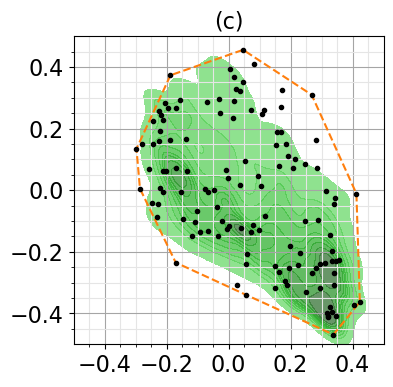

In [3]:
ConvexHull_weight, TDKS_uniform_circle_weight = 1,1
R = 0.5
x0 = 0
y0 = 0
normalise = False
fill = True
alpha = 0.75
thresh = 0.02

x = pd.concat((df_ref['isopl_1st_half'],df_ref['isopl_2nd_half'])).to_numpy().squeeze()
y = pd.concat((df_ref['isoev_1st_half'],df_ref['isoev_2nd_half'])).to_numpy().squeeze()

L = representative_loss(
    x,y,
    ConvexHull_weight = ConvexHull_weight,
    TDKS_uniform_circle_weight = TDKS_uniform_circle_weight,
    TDKS_uniform_circle_kwargs = {
        'R': R,
        'x0': x0,
        'y0': y0,
        'normalise': normalise,
    }
)
A = representative_loss(
    x,y,
    ConvexHull_weight = 1,
    TDKS_uniform_circle_weight = 0,
    TDKS_uniform_circle_kwargs = {
        'R': R,
        'x0': x0,
        'y0': y0,
        'normalise': normalise,
    }
)
D = representative_loss(
    x,y,
    ConvexHull_weight = 0,
    TDKS_uniform_circle_weight = 1,
    TDKS_uniform_circle_kwargs = {
        'R': R,
        'x0': x0,
        'y0': y0,
        'normalise': normalise,
    }
)
print(f"Representative loss = {L:.2f}; Convex hull area = {-A:.2f}; Peacock's test statistic = {D:.2f}")

CH = scipy.spatial.ConvexHull(np.stack((x,y)).T)
CH_idxs = np.concatenate((CH.vertices, np.array([CH.vertices[0]])))
# Note: matplotlib default colour order = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']

plt.figure(figsize=(4,4))
plt.title('(c)',fontsize=16)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
sns.kdeplot(pd.read_csv(os.path.join('..','predictions.csv')),
            x = 'isopl_mean',
            y = 'isoev_mean',
            color = '#2ca02c',
            fill = fill,
            alpha = alpha,
            thresh = thresh)
plt.plot(x[CH_idxs], y[CH_idxs], '--', color = '#ff7f0e')
plt.plot(x,y,'k.')
plt.xticks(ticks=[-0.4,-0.2,0.0,0.2,0.4],fontsize=16)
plt.yticks(ticks=[-0.4,-0.2,0.0,0.2,0.4],fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.grid(which='major', color = '#A5A5A5')
plt.grid(which='minor', color = '#E5E5E5')
plt.minorticks_on()

Expected output of the above block:

<img src="../figures/distribution_observed_actual_79.png">

Note that the indices in the final reference file `./results/Seed_12_Epoch_079_Loss_-0.316262_Reference.csv` match the 1-minute offset values in the metadata file `metadata.csv` exactly, which correspond to the actual timestamps that we cut the 1-minute excerpts for the LCS dataset:

In [3]:
df_meta = pd.read_csv(os.path.join('..','metadata.csv'))
df1 = df_meta.apply(lambda x: (x['onemin_offset_bin_minutes'],x['onemin_offset_bin_seconds']),axis=1)
df2 = df_ref.sort_values('prediction_fpath')['start_idxs'].apply(lambda x: (x//60, x%60)).reset_index(drop=True)
(df1 == df2).all()

True

Expected output of the above block:
```
True
```

## Twenty seeds (as reported) <a name="twenty_seeds">

The following block was what we ran to obtain the results for all twenty seeds (1 to 20 inclusive) for the ICSV publication. The code is not optimized for parallel processing, so the total time taken will be extremely long. However, we include it here for the sole purpose of replicability, and leave optimization as future work.

In [ ]:
ConvexHull_weight, TDKS_uniform_circle_weight = 1,1
R = 0.5
x0 = 0
y0 = 0
normalise = False

for seed_val in range(1,21):
    # Initialisation
    LCS_points = lcs_points()
    df = LCS_points.random_choice(seed_val = seed_val, restrict=True)
    x = pd.concat((df['isopl_1st_half'],df['isopl_2nd_half'])).to_numpy().squeeze()
    y = pd.concat((df['isoev_1st_half'],df['isoev_2nd_half'])).to_numpy().squeeze()

    L = representative_loss(
        x,y,
        ConvexHull_weight = ConvexHull_weight,
        TDKS_uniform_circle_weight = TDKS_uniform_circle_weight,
        TDKS_uniform_circle_kwargs = {
            'R': R,
            'x0': x0,
            'y0': y0,
            'normalise': normalise,
        }
    )
    df.to_csv(os.path.join('..','results',f"Seed_{seed_val:02d}_Epoch_000_Loss_{L:.6f}.csv"),index=False)

    # Refinement
    np.random.seed(2023)
    counter = 0
    best_L = np.inf
    while True:
        counter += 1
        print(f'\nCounter = {counter}')
        new_L, df = swap_points(df, LCS_points.paired_predictions_in_quadrants, verbose = 1)
        if new_L < best_L:
            best_L = new_L
            df.to_csv(os.path.join('..','results',f"Seed_{seed_val:02d}_Epoch_{counter:03d}_Loss_{new_L:.6f}.csv"),index=False)
        else:
            break

For convenience, we have uploaded the results we obtained from the above block into our institutional repository, which you may download and extract with the following block, or manually download at https://doi.org/10.21979/N9/AVHSBX.

In [22]:
results_url = 'https://researchdata.ntu.edu.sg/api/access/datafile/112430?gbrecs=true'
wget.download(results_url,out='..')
with ZipFile(os.path.join('..','results.zip')) as fp:
    fp.extractall('..')

We verify that seed 12 is indeed the seed returning the lowest loss function value from 1 to 20 (inclusive):

In [26]:
best_seed_val = 0
best_L = np.inf
for seed_val in range(1,21):
    flist = glob.glob(os.path.join('..','results',f'Seed_{seed_val:02d}*.csv'))
    flist.sort()
    best_epoch_fpath = flist[-1]
    df = pd.read_csv(best_epoch_fpath)
    x = pd.concat((df['isopl_1st_half'],df['isopl_2nd_half'])).to_numpy().squeeze()
    y = pd.concat((df['isoev_1st_half'],df['isoev_2nd_half'])).to_numpy().squeeze()

    L = representative_loss(
        x,y,
        ConvexHull_weight = ConvexHull_weight,
        TDKS_uniform_circle_weight = TDKS_uniform_circle_weight,
        TDKS_uniform_circle_kwargs = {
            'R': R,
            'x0': x0,
            'y0': y0,
            'normalise': normalise,
        }
    )
    if L < best_L:
        best_seed_val = seed_val
        best_L = L
print(f'best_seed_val = {best_seed_val}, best_L = {best_L}')

best_seed_val = 12, best_L = -0.31626187558783053


Expected output of the above block:
```
best_seed_val = 12, best_L = -0.31626187558783053
```